# IMPORT LIBRARIES

In [1]:
# Import necessary libraries
import BiQ_Common_Fxns as BiQ
import numpy as np  # for numerical operations
import pandas as pd  # for data manipulation and analysis
import matplotlib.pyplot as plt  # for creating plots
import itertools  # for iterators and looping functions
import math  # for mathematical operations
import statsmodels.formula.api as smf  # for statistical modeling
import statsmodels.api as sm  # for statistical analysis and modeling

# EXTRACT DATA FROM WORKSHEET

In [2]:
# Initialize a global variable to store DataFrame read from Excel
global_df = None

def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    global global_df  # Access the global DataFrame variable
    try:
        df = pd.read_excel(file_path)  # Read Excel file into a temporary DataFrame
        df = df.dropna(axis=1, how='all')  # Drop columns that are entirely blank
        global_df = df.copy()  # Assign the modified DataFrame to the global variable
        return global_df  # Return the DataFrame
    except Exception as e:
        print(f"Error reading Excel file: {e}")  # Print error message if file reading fails
        return None  # Return None if an error occurs

def extract_factor_values(df, factors_column):
    """Extracts unique factor values from the specified column."""
    try:
        factor_values = df[factors_column].dropna().unique()  # Extract unique factor values from specified column
        return factor_values  # Return the unique factor values
    except Exception as e:
        print(f"Error extracting factor values: {e}")  # Print error message if extraction fails
        return None  # Return None if an error occurs

def process_excel_file(file_paths):
    """Processes the selected Excel file."""
    if file_paths:  # Check if file paths are provided
        results_file = file_paths[0]  # Get the first file path from the list
        factors_column = 'Factor'  # Define the column name containing factors
        df = read_excel_file(results_file)  # Read Excel file into DataFrame
        if df is not None:  # Check if DataFrame is successfully loaded
            factor_values = extract_factor_values(df, factors_column)  # Extract factor values from DataFrame
            return df, factor_values  # Return the DataFrame and factor values
    return None, None  # Return None for DataFrame and factor values if file loading fails

def main():
    file_paths, _ = BiQ.open_file_dialog()  # Open a file dialog to select Excel file(s)

    if file_paths:  # Check if file paths are provided
        results_file = file_paths[0]  # Get the first file path from the list
        df = read_excel_file(results_file)  # Read Excel file into DataFrame
        if df is not None:  # Check if DataFrame is successfully loaded
            # Perform additional processing logic here
            pass
    else:
        print("No file selected.")  # Print message if no file is selected

    # Display the global DataFrame
    display(global_df)  # Display the global DataFrame

# Call the main function if the script is executed directly
if __name__ == "__main__":
    main()


Selected files:
C:/Users/ChrisSaid/Boulder BioMed/Engineering - Documents/Cerapedics/3- Consultant Working Documents/Pulverizing Sieving/Sieve Counterweight Adjustment Study/DOE Worksheet (GAP1 v Profile).xlsx [DOE Worksheet (GAP1 v Profile).xlsx]


,Factor,Levels,Data Type,UCW,LCW,LA,Results
0,UCW,3.0,Categorical,-1,-1,-1,12.240933
1,LCW,2.0,Categorical,0,-1,-1,2.014792
2,LA,2.0,Categorical,1,-1,-1,3.170645
3,NaN,NaN,NaN,-1,1,-1,11.873921
4,NaN,NaN,NaN,0,1,-1,3.315481
5,NaN,NaN,NaN,1,1,-1,4.666904
6,NaN,NaN,NaN,-1,-1,1,32.426598
7,NaN,NaN,NaN,0,-1,1,2.193318
8,NaN,NaN,NaN,1,-1,1,4.310652
9,NaN,NaN,NaN,-1,1,1,2.094128


# ANALYSIS

## MAIN EFFECTS PLOT

In [3]:
# Define a function to plot main effects
def main_effects_plot(df):
    """Plots main effects based on the DataFrame."""
    if df is None:
        print("DataFrame is empty.")
        return
    
    # Assuming 'Factor' and 'Results' are columns in the DataFrame
    factors_column = 'Factor'
    results_column = 'Results'
    
    # Extract unique factor values
    factors = df[factors_column].dropna().unique()
    
    # Calculate main effects
    main_effects = {}
    for factor in factors:
        # Calculate mean for positive and negative levels of each factor
        mean_plus = df[df[factor] == 1][results_column].mean()
        mean_minus = df[df[factor] == -1][results_column].mean()
        # Compute the main effect as the difference between means
        main_effects[factor] = mean_plus - mean_minus

    # Plot main effects
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.bar(main_effects.keys(), main_effects.values())

    # Annotate the bars with their values
    for factor, value in main_effects.items():
        ax.text(factor, value + 0.01 * abs(value), '{:.2f}'.format(value), ha='center', va='bottom')

    # Set labels and title
    ax.set_ylabel('Main Effect')
    ax.set_title('Main Effects Plot')
    plt.xticks(rotation=45, ha="right")
    plt.show()


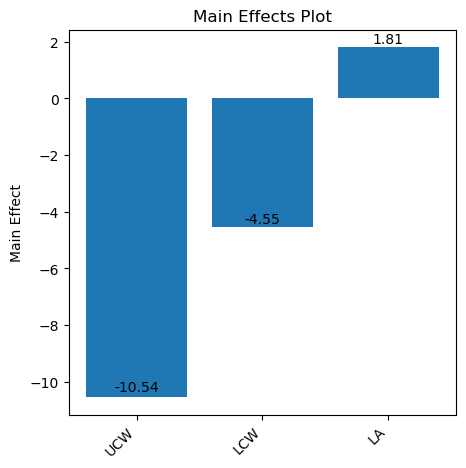

In [4]:
# Call the function
main_effects_plot(global_df)

## INTERACTION PLOTS

### INTERACTION EFFECTS PLOT

In [5]:
def interaction_effects_plot(df, results_column):
    """
    Plots interaction effects based on the DataFrame and results_column.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - results_column (str): Name of the column containing the results.
    """
    if df is None or df.empty:  # Check if DataFrame is empty
        print("DataFrame is empty.")
        return

    # Filter columns based on exclusion criteria
    interest_columns = [col for col in df.columns if col not in ['Results', 'Factor', 'Levels', ''] and df[col].notnull().any()]
    
    # Filter combinations to include only those involving interest_columns
    interactions = list(itertools.combinations(interest_columns, 2))
    
    # Initialize lists to store interaction labels and effects
    interaction_labels = []
    interaction_effects = []
    
    # Calculate interaction effects
    for interaction in interactions:
        try:
            # Group data by the current interaction and calculate mean for results_column
            grouped = df.groupby(list(interaction))[results_column].mean()
            # Calculate interaction effect
            interaction_effect = (grouped[(1, 1)] - grouped[(1, -1)] - grouped[(-1, 1)] + grouped[(-1, -1)]) / 2
            # Append interaction label and effect to respective lists
            interaction_labels.append(f"{interaction[0]} x {interaction[1]}")
            interaction_effects.append(interaction_effect)
        except KeyError:
            # Handle KeyError if the current interaction is not found in the data
            print(f"Interaction {interaction} not found in the data. Skipping.")
            continue

    # Plot the interaction effects if both lists have the same length and are not empty
    if interaction_labels and interaction_effects:
        # Create a bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(interaction_labels, interaction_effects)

        # Add the exact numbers above the bars
        for i, v in enumerate(interaction_effects):
            ax.text(i, v + 0.01 * max(interaction_effects), round(v, 2), ha='center', va='bottom')

        ax.set_ylabel("Interaction Effect")  # Set label for y-axis
        ax.set_title("Two-way Interaction Effects")  # Set title for the plot
        plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
        plt.tight_layout()  # Adjust layout
        plt.show()  # Display the plot
    else:
        print("No valid interaction effects found.")  # Print message if no valid effects are found


Interaction ('Data Type', 'UCW') not found in the data. Skipping.
Interaction ('Data Type', 'LCW') not found in the data. Skipping.
Interaction ('Data Type', 'LA') not found in the data. Skipping.


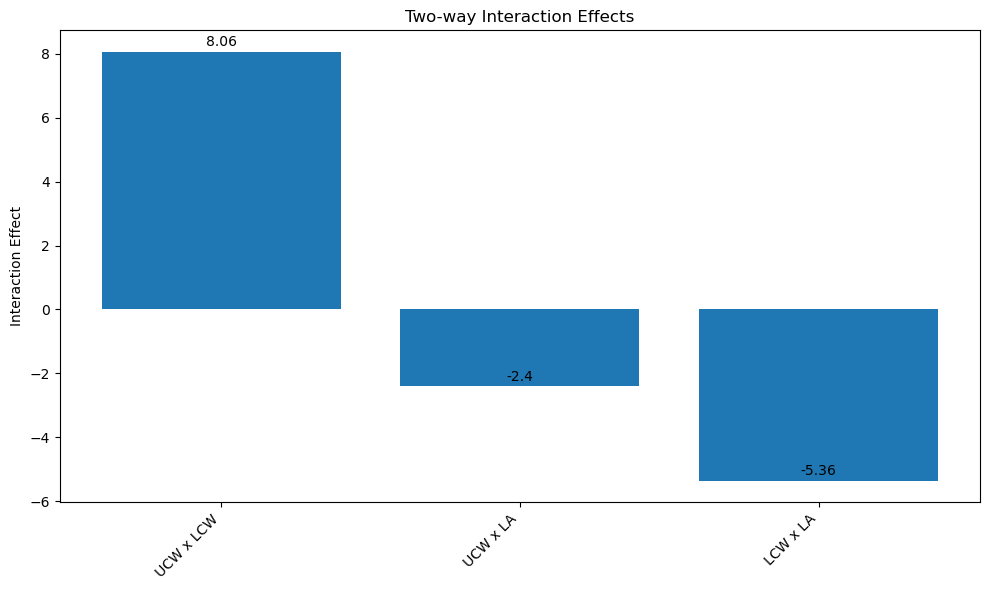

In [6]:
interaction_effects_plot(global_df, 'Results')

### INTERACTION POINT PLOT

In [7]:
def interaction_point_plot(df, results_column):
    """
    Plots interaction point plot based on the DataFrame and results_column.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - results_column (str): Name of the column containing the results.
    """
    if df is None:  # Check if DataFrame is empty
        print("DataFrame is empty.")
        return
    
    # Filter columns based on exclusion criteria
    factors = [col for col in df.columns if col not in ['Results', 'Factor', 'Levels', ''] and df[col].notnull().any()]
    
    # Filter combinations to include only those involving factors
    interactions = list(itertools.combinations(factors, 2))

    # Display interactions
    display(interactions)
    
    # Calculate number of rows and columns for subplots
    cols = 3
    rows = math.ceil(len(interactions) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10*rows/3))

    for idx, interaction in enumerate(interactions):
        row = idx // cols
        col = idx % cols

        ax = axs[row, col] if rows > 1 else axs[col]

        # Plot interaction point for each level of the first factor
        for level in [-1, 1]:
            subset = df[df[interaction[0]] == level]
            ax.plot(subset[interaction[1]].unique(), subset.groupby(interaction[1])[results_column].mean(), 'o-', label=f'{interaction[0]} = {level}')

        ax.set_title(f'{interaction[0]} x {interaction[1]}')  # Set title for the subplot
        ax.legend()  # Add legend to the subplot
        ax.grid(True)  # Add grid to the subplot

    # Handle any remaining axes (if there's no data to plot in them)
    for idx in range(len(interactions), rows*cols):
        row = idx // cols
        col = idx % cols
        axs[row, col].axis('off')  # Turn off axes for empty subplots

    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plot

[('Data Type', 'UCW'),
 ('Data Type', 'LCW'),
 ('Data Type', 'LA'),
 ('UCW', 'LCW'),
 ('UCW', 'LA'),
 ('LCW', 'LA')]

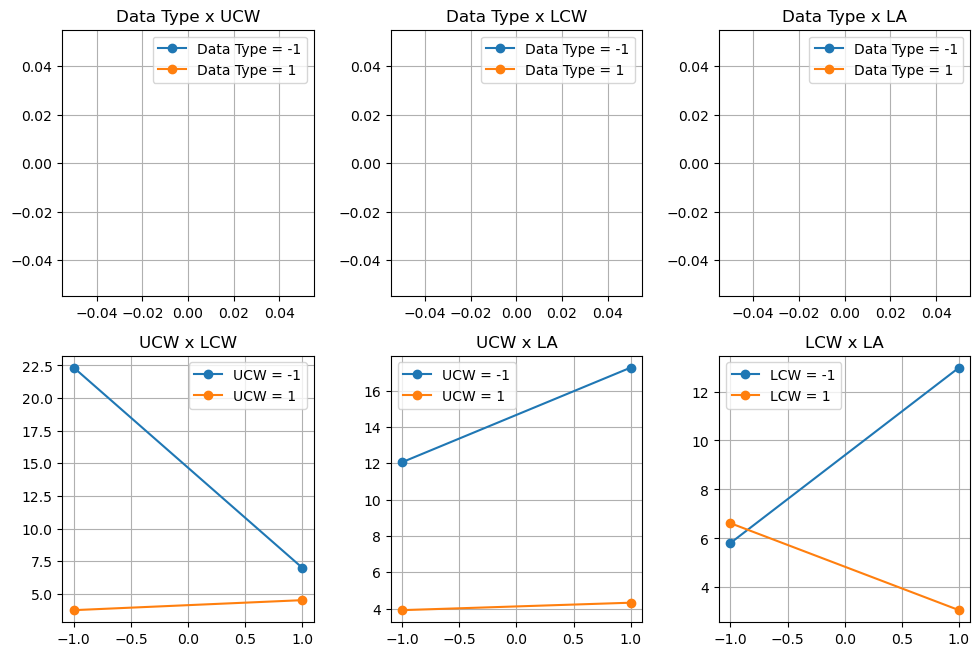

In [8]:
interaction_point_plot(global_df, 'Results')

## ANOVA TABLE

In [9]:
# Extract unique non-nan values from the 'Factor' column and convert them to strings
factors = [str(factor) for factor in global_df['Factor'].unique() if pd.notnull(factor)]

# Generate combinations of two factors
factor_combinations = list(itertools.combinations(factors, 2))

# Construct the formula string
formula_parts = []

# Add individual factors
formula_parts.extend(factors)

# Generate interaction terms
interaction_terms = [f'{f1}:{f2}' for f1, f2 in factor_combinations]
formula_parts.extend(interaction_terms)

formula_string = 'Results ~ ' + ' + '.join(formula_parts)

print(formula_string)

# Fit the model using ordinary least squares (OLS)
# This step performs the regression analysis
model = sm.formula.ols(formula_string, data=global_df).fit()

Results ~ UCW + LCW + LA + UCW:LCW + UCW:LA + LCW:LA


## MODEL SUMMARY

In [10]:
# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Results   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     1.384
Date:                Mon, 25 Mar 2024   Prob (F-statistic):              0.369
Time:                        14:19:37   Log-Likelihood:                -36.616
No. Observations:                  12   AIC:                             87.23
Df Residuals:                       5   BIC:                             90.63
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1173      2.288      3.111      0.0

c:\Users\ChrisSaid\anaconda3\envs\BiQ_env_20231205\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## MODEL DIAGNOSTICS

In [11]:
def diagnostic_plots(model):
    # Extract residuals and predicted values from the model
    residuals = model.resid
    predicted = model.fittedvalues
    
    # Create subplots with one row and three columns
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))  # Creating a figure and axes for subplots
    
    # Residuals vs Fits
    axs[0].scatter(predicted, residuals, edgecolors='k', facecolors='none')  # Scatter plot of predicted vs residuals
    axs[0].axhline(y=0, color='k', linestyle='dashed', linewidth=1)  # Horizontal line at y=0
    axs[0].set_title('Residuals vs. Fits')  # Setting title for the subplot
    axs[0].set_xlabel('Fit values')  # Setting label for x-axis
    axs[0].set_ylabel('Residuals')  # Setting label for y-axis
    
    # Residuals vs. Order (Order of Data Collection)
    axs[1].scatter(range(len(residuals)), residuals, edgecolors='k', facecolors='none')  # Scatter plot of residuals vs runs
    axs[1].axhline(y=0, color='k', linestyle='dashed', linewidth=1)  # Horizontal line at y=0
    axs[1].set_title('Residuals vs. Order')  # Setting title for the subplot
    axs[1].set_xlabel('Order')  # Setting label for x-axis
    axs[1].set_ylabel('Residuals')  # Setting label for y-axis
    
    # Q-Q plot
    sm.qqplot(residuals, line='45', fit=True, ax=axs[2])  # Q-Q plot of residuals
    axs[2].set_title('Q-Q Plot')  # Setting title for the subplot
    
    plt.tight_layout()  # Adjusting layout to prevent overlap
    plt.show()  # Displaying the plots

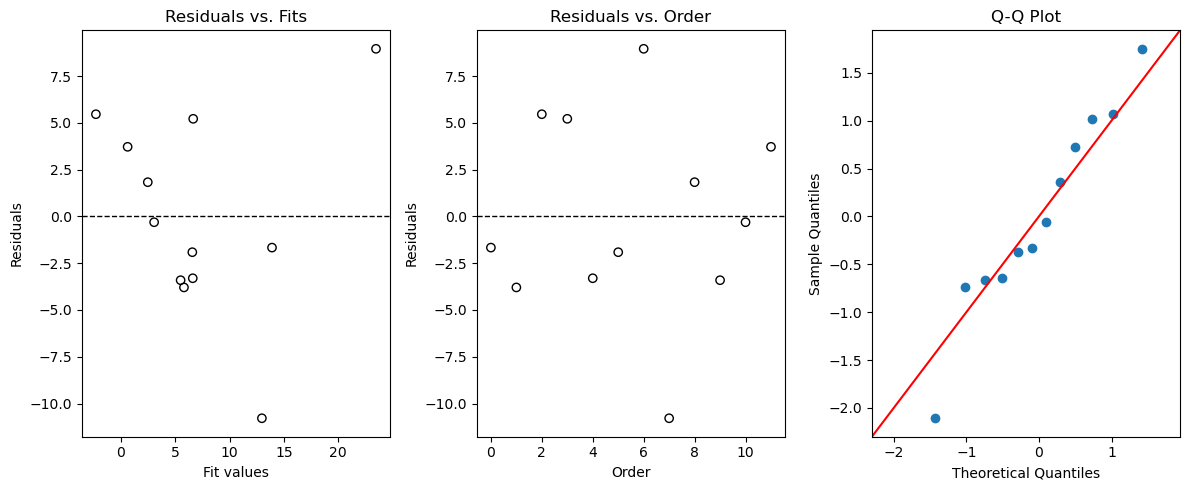

In [12]:
diagnostic_plots(model)

## 3D SURFACE PLOTS

### HELD VALUE = 1

TypeError: '<=' not supported between instances of 'str' and 'float'

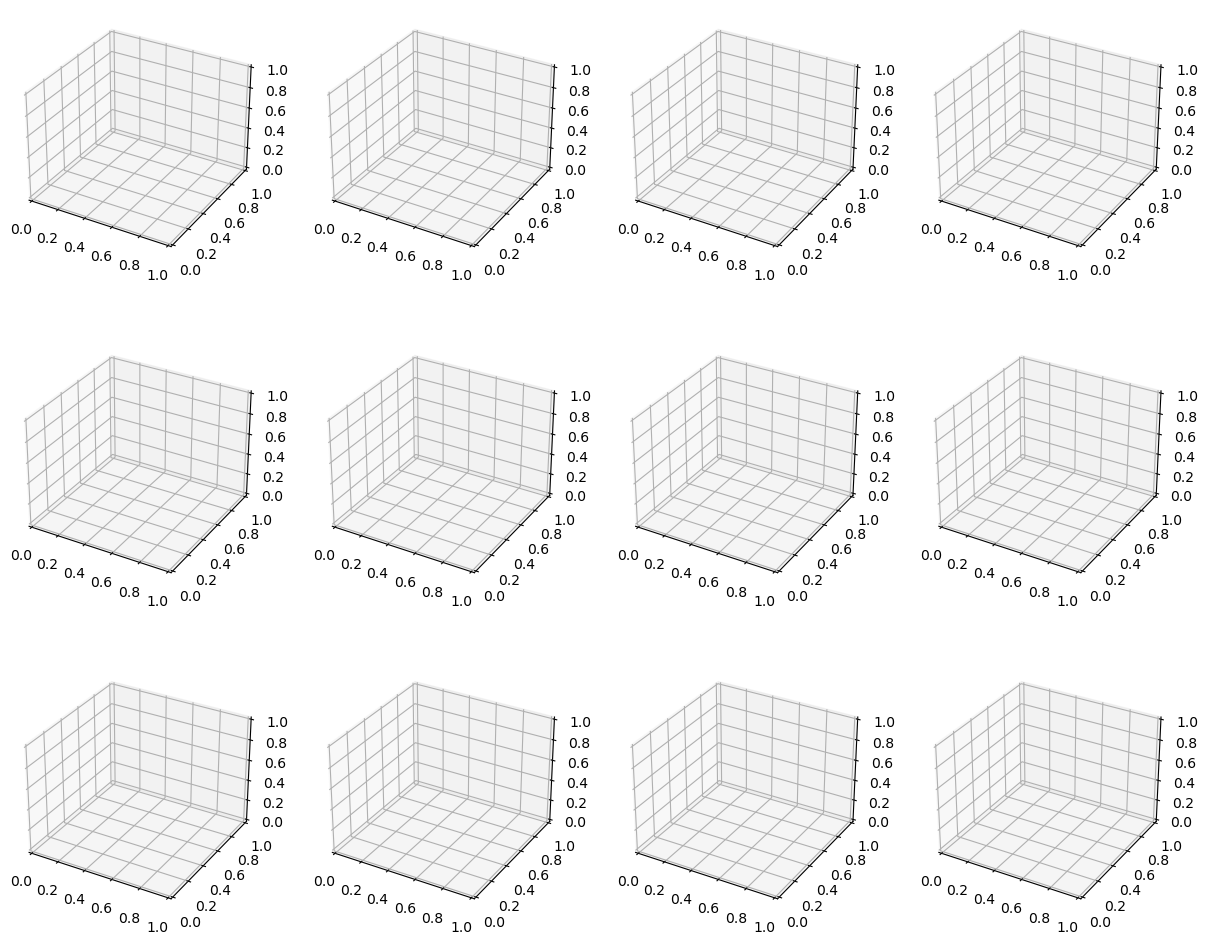

In [13]:
def plot_3D_surface(title, df, model, held_value, num_values=10):
    # Filter out columns that you don't want
    factors = [col for col in df.columns if col not in ['Factor', 'Levels', '', 'Results'] and col is not None]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factors, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4), subplot_kw={'projection': '3d'})
    
    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factors if factor != x_name and factor != y_name]
        
        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()
        
        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a dataframe
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result
        
        # Plotting the surface
        ax = axes[i // 4, i % 4]
        ax.plot_surface(A_values, B_values, Z, cmap='viridis', alpha=0.6)
        
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_zlabel('Results')
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')
    
    plt.tight_layout()
    plt.show()

# Assuming you have defined your title, global_df, held_value, and model elsewhere in your code
plot_3D_surface("3D Surface Plot", global_df, model, 1)

### HELD VALUE = -1

In [ ]:
def plot_3D_surface(title, df, model, held_value, num_values=10):
    # Filter out columns that you don't want
    factors = [col for col in df.columns if col not in ['Factor', 'Levels', '', 'Results'] and col is not None]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factors, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4), subplot_kw={'projection': '3d'})
    
    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factors if factor != x_name and factor != y_name]
        
        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()
        
        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a dataframe
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result
        
        # Plotting the surface
        ax = axes[i // 4, i % 4]
        ax.plot_surface(A_values, B_values, Z, cmap='viridis', alpha=0.6)
        
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_zlabel('Results')
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')
    
    plt.tight_layout()
    plt.show()

# Assuming you have defined your title, global_df, held_value, and model elsewhere in your code
plot_3D_surface("3D Surface Plot", global_df, model, -1)

## CONTOUR PLOTS

### HELD VALUE = 1

In [ ]:
def plot_contour(title, df, model, held_value, num_values=10):
    # Filter out columns that you don't want
    factors = [col for col in df.columns if col not in ['Factor', 'Levels', '', 'Results'] and col is not None]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factors, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))
    
    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factors if factor != x_name and factor != y_name]
        
        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()
        
        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a dataframe
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result
        
        # Plotting the contour plot
        ax = axes[i // 4, i % 4]
        contour = ax.contourf(A_values, B_values, Z, cmap='viridis')
        fig.colorbar(contour, ax=ax)
        
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')
    
    plt.tight_layout()
    plt.show()

# Assuming you have defined your title, global_df, held_value, and model elsewhere in your code
plot_contour("Contour Plot", global_df, model, 1)

### HELD VALUE = -1

In [ ]:
def plot_contour(title, df, model, held_value, num_values=10):
    # Filter out columns that you don't want
    factors = [col for col in df.columns if col not in ['Factor', 'Levels', '', 'Results'] and col is not None]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factors, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))
    
    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factors if factor != x_name and factor != y_name]
        
        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()
        
        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a dataframe
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result
        
        # Plotting the contour plot
        ax = axes[i // 4, i % 4]
        contour = ax.contourf(A_values, B_values, Z, cmap='viridis')
        fig.colorbar(contour, ax=ax)
        
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')
    
    plt.tight_layout()
    plt.show()

# Assuming you have defined your title, global_df, held_value, and model elsewhere in your code
plot_contour("Contour Plot", global_df, model, -1)

## RESPONSE OPTIMIZATION

In [ ]:

def optimize_response(df, model, step_size=None):
    """
    Optimizes the response based on the given model and DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - model (statsmodels.regression.linear_model.RegressionResultsWrapper): Fitted regression model.
    - step_size (float or None): Step size for increments. If None, only integers -1 and 1 are used.

    Returns:
    - dict: Dictionary containing the optimized settings and predicted response value.
    """
    if df.empty or model is None:
        return {"Optimized Settings": None, "Optimized Response": None}

    # Define factors
    factors = [col for col in df.columns if col not in ['Factor', 'Levels', 'Results'] and col.strip()]

    # Calculate the number of levels for each factor
    num_levels = {factor: len(df[factor].unique()) for factor in factors}

    # Generate all possible combinations of factor levels
    if step_size is not None:
        value_combinations = itertools.product(np.arange(-1, 1+step_size, step_size), repeat=len(factors))
    else:
        # Generate integers based on the number of levels for each factor
        integers = {factor: [-1, 1] if num_levels[factor] == 2 else [-1, 0, 1] for factor in factors}
        value_combinations = itertools.product(*[integers[factor] for factor in factors])

    # Initialize variables for optimized settings and response value
    optimized_settings = None
    optimized_response = None

    # Iterate over each combination of factor values
    for values in value_combinations:
        
        # Create a DataFrame with the current combination of factor values
        data = pd.DataFrame({factor: [value] for factor, value in zip(factors, values)})
        
        # Predict response for the current combination
        predicted_response = model.predict(data).iloc[0]  # Extract the predicted value
        
        # Check if the predicted response is better than the previous best
        if optimized_response is None or predicted_response > optimized_response:
            optimized_response = predicted_response
            optimized_settings = {factor: value for factor, value in zip(factors, values)}

    return {"Optimized Settings": optimized_settings, "Optimized Response": optimized_response}

# Call the function to optimize response with integers based on the number of levels for each factor
optimization_result_integers = optimize_response(global_df, model)

print("Optimization Result with Integers based on Number of Levels for Each Factor:")
display(optimization_result_integers)

Optimization Result with Integers based on Number of Levels for Each Factor:


{'Optimized Settings': {'Data Type': -1, 'UCW': -1, 'LCW': -1, 'LA': -1},
 'Optimized Response': 2.009610742863573}